## STAT 628 Module 2

# Body Fat Prediction
Authors (Thurs_Group3): Zheng Ni, Jingpeng Weizhou, Zifeng Wang, Ke Chen

## 1. Introduction

As a measurement of obesity, Body Fat Percentage is a crucial index for describing health condition. In fact, many reserachers have proposed  various accurate way to calculate body fat percentage, while these methods always require costly measurement. In hence, we would like to construct a simple but also precise "rule of thumb" method to predict body fat percentage of males using available clinical measurements.

In this project, we try with multiple linear regression models with different subset of features and finally choose the best model with highest accuracy and robustness.


## 2. Data Description

The dataset contains 252 men with measurements of their percentage of body fat and various body circumference measurements. Overall, the response variable is **BODYFAT** and there are 16 explained variables including **AGE,WEIGHT,HEIGHT**, etc. The following table shows the structure of our dataset.

In [4]:
setwd('/Users/kechen/WISC/628/Module 2')
data = read.csv('BodyFat.csv',header = TRUE)
data[1:5,]

IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
1,12.6,1.0708,23,154.25,67.75,23.7,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
2,6.9,1.0853,22,173.25,72.25,23.4,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
3,24.6,1.0414,22,154.00,66.25,24.7,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
4,10.9,1.0751,26,184.75,72.25,24.9,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
5,27.8,1.0340,24,184.25,71.25,25.6,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


Based on previous research, we know that **DENSITY** is almost perfectly correlated with **BODYFAT**, which can also be captured by the formula, **BODYFAT = 495/DENSITY - 450**. Consequently, we cannot view **DENSITY** as a reliable variable.

The following table are the explained variables we would use in the our model.

|**AGE**|**WEIGHT**|**HEIGHT**|**ADIPOSITY**|**NECK**|**CHEST**|**ABDOMEN**|**HIP**|**THIHG**|**KNEE**|**ANKLE**|**BICEPS**|**FOREARM**|**WRIST**|
|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
|years|lbs|inches|bmi|cm|cm|cm|cm|cm|cm|cm|cm|cm|cm|

## 3. Data Preprocessing

Before we go into modeling part, we have to check whether there are missing values and outliers in our model. Based on the code below, we find there is no missing values in our dataset, so we don't need to use imputation method. As for the outliers, we would check the boxplot first to see if there are some data beyond 75% quantile.

From the boxplots below, we find some people have extremely low height, some have extremely high weight and bodyfat and even one man has 0 bodyfat which are beyond the possible range. So we think these records are outliers.

Number of missing values: 0 
Outliers: 42 39 216 41 31 86 159 175 226

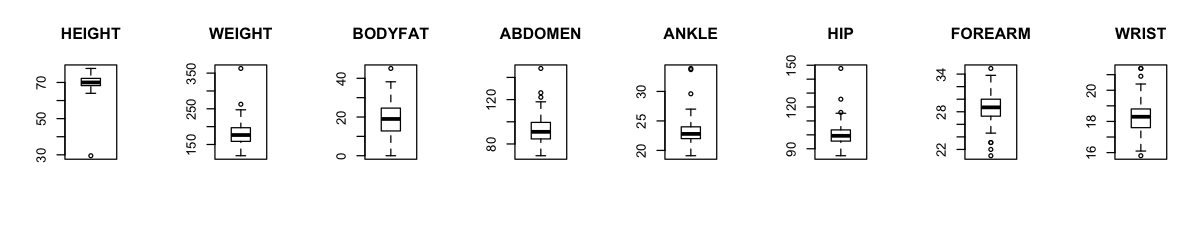

In [5]:
options(repr.plot.width=10, repr.plot.height=2)
cat('Number of missing values:',sum(is.na(data)),'\n')
par(mfrow=c(1,8))
boxplot(data$HEIGHT,main='HEIGHT');boxplot(data$WEIGHT,main='WEIGHT') 
boxplot(data$BODYFAT,main='BODYFAT');boxplot(data$ABDOMEN,main='ABDOMEN')
boxplot(data$ANKLE,main='ANKLE');boxplot(data$HIP,main='HIP')
boxplot(data$FOREARM,main='FOREARM');boxplot(data$WRIST,main='WRIST')
cat('Outliers:',unique(c(which(data$HEIGHT<40),which(data$WEIGHT>300),which(data$BODYFAT>40),
                 which(data$ABDOMEN>120),which(data$ANKLE>30),which(data$HIP>120),which(data$FOREARM>34),
                  which(data$FOREARM<22),which(data$WRIST<16))))

After detecting the outliers, we try with the following methods to deal with the outliers.
1. Fisrtly, we use some BMI function(**BMI(ADIPOSITY) = WEIGHT/(HEIGHT^2) * 703**) and the relation between BODYFAT and DENSITY proposed by researchers (**BODYFAT = 495/DENSITY - 450**). These functions can help us to compute the value of outliers.
2. Secondly, we utilize regression imputation method. We regress the outlier feature on other related features and get the estimate of the real value of the outliers.
3. Finally, for those data which are consistent with the function above, they might not due to inaccurate measurement. They may be some extreme values which are far from other data, we mainly choose to drop these records in order to get more precise analysis.

In [6]:
# BY BMI FUNCTION
data[,'HEIGHT'][42] = sqrt(205*703/29.9)
data[,'ADIPOSITY'][221] = 153.25/70.50^2*703
# Regression IMPUTATION
data[,'WRIST'][226] = 6.5+0.26*data[,'ANKLE'][226]+0.18*data[,'KNEE'][226]+0.02*data[,'AGE'][226] # lm(WRIST~ANKLE+KNEE+AGE)
data[,'ANKLE'][31] = 3.1+0.56*data[,'WRIST'][31]+0.28*data[,'KNEE'][31]-0.02*data[,'AGE'][31] # lm(ANKLE~WRIST+KNEE+AGE))
data[,'ANKLE'][86] = 3.1+0.56*data[,'WRIST'][86]+0.28*data[,'KNEE'][86]-0.02*data[,'AGE'][86] # lm(ANKLE~WRIST+KNEE+AGE)
# DROP OUTLIERS
data = data[-c(39,41,216),]

## 4. Model Selection

After data cleaning, we find there are so many variables which may be correlation among them. In order to get a precise model, we would use stepwise method for feature selection. In order to find the best model, we try with both forward and backward selection using criterions as AIC,BIC,R2. These methods have some consistent results indicating
**ABDOMEN, WEIGHT, WRIST** are the most important features. Here, we mainly shows the result of forward selection using BIC criterion.

In [13]:
bic_forward = step(min_model,direction = 'forward',scope = biggest,trace = 0,k=log(length(data[,1])))
bic_forward


Call:
lm(formula = Y ~ ABDOMEN + WEIGHT + WRIST, data = X)

Coefficients:
(Intercept)      ABDOMEN       WEIGHT        WRIST  
  -25.68435      0.88743     -0.08671     -1.20254  


Since the **ABDOMEN** is the most significant one with smallest p-value, it must be the most important variable to be selected. For **WEIGHT** and **WRIST**, they are both statistically significant, however, based on the "Rule of Thumb" we had better drop one of them in order to make our model simple. To make better trade-off, we further compare these two models to decide which variable should be kept.

In [17]:
Model_1 <- lm(Y ~ X$ABDOMEN + X$WEIGHT)
Model_2 <- lm(Y ~ X$ABDOMEN + X$WRIST)
cat('R2 of model with WEIGHT',summary(Model_1)$r.squared,',R2 of model with WRIST',summary(Model_2)$r.squared)
Model_1

R2 of model with WEIGHT 0.7102751 ,R2 of model with WRIST 0.7030952


Call:
lm(formula = Y ~ X$ABDOMEN + X$WEIGHT)

Coefficients:
(Intercept)    X$ABDOMEN     X$WEIGHT  
   -43.1062       0.9005      -0.1187  


Comparing the models with **ABDOMEN,WEIGHT** and **ABDOMEN,WRIST**, we can see the R-squared for the model with **WEIGHT** is higher which suggests it has better performance. In hence, we determine our final model in the form of linear regression with variables **ABDOMEN** and **WEIGHT**.